In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import seaborn as sns

from os.path import join

plt.style.use(["seaborn", "thesis"])


/home/jo/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
plt.rc("figure", figsize= (8, 4))

# Fetch Dataset 

In [3]:
from SCFInitialGuess.utilities.dataset import AbstractDataset


data_path = "../../dataset/EthenT/"
postfix = "EthenT"
dim = 72
basis = "6-311++g**"
n_electrons = 16
#data_path = "../butadien/data/"
#postfix = ""
#dim = 26


S = np.load(join(data_path, "S" + postfix + ".npy"))
P = np.load(join(data_path, "P" + postfix + ".npy"))

index = np.load(join(data_path, "index" + postfix + ".npy"))

molecules = np.load(join(data_path, "molecules" + postfix + ".npy"))


ind = int(0.8 * len(index))
ind_val = int(0.8 * ind)


molecules = (
    molecules[:ind_val], 
    molecules[ind_val:ind], 
    molecules[ind:]
)

s_triu_norm, mu, std = AbstractDataset.normalize(S)


def split(x, y, ind):
    return x[:ind], y[:ind], x[ind:], y[ind:]

s_train, p_train, s_test, p_test = split(S, P, ind)
s_train, p_train, s_val, p_val = split(s_train, p_train, ind_val)

#  Define Candidates

In [4]:
from SCFInitialGuess.descriptors.cutoffs import behler_cutoff_1

def plot_cutoff_model(model, R_c, t=None):
    mus, sigmas = model
    
    if t is None:
        t = np.linspace(0, 1.2 * R_c, 200)
    
    for r_s, eta in zip(mus, sigmas):
        plt.plot(
            t, 
            np.exp(-1 * eta*(t - r_s)**2) * \
            behler_cutoff_1(t, R_c)
        )

def plot_damped_model(model, tau, t=None):
    mus, sigmas = model
    
    if t is None:
        t = np.linspace(0, 1.2 * tau, 200)
    
    for r_s, eta in zip(mus, sigmas):
        plt.plot(
            t, 
            np.exp(-1 * eta*(t - r_s)**2) * \
            np.exp(- t / tau)
        )
        
def plot_normal_model(model, t):
    for r_s, eta in zip(model[0], model[1]):
        plt.plot(t, np.exp(-1 * eta*(t - r_s)**2))
        
def plot_periodic_model(model, t):
    period = model[2]
    for r_s, eta in zip(model[0], model[1]):
        plt.plot(t,
            np.exp(-1 * eta * ((t % period) - r_s)**2) + \
            np.exp(-1 * eta * ((t % period) - period - r_s)**2)
        )

## Radial


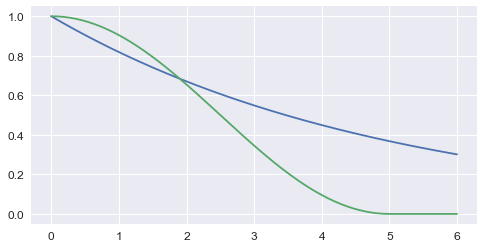

In [5]:
x = np.linspace(0, 6, 200)
plt.plot(x, np.exp(-x / 5))
plt.plot(x, behler_cutoff_1(x, 5))
plt.show()

### Origin Centered 

In [6]:
r_model_origin = (
    [0.0] * 50,
    np.linspace(10, 0.1, 50)
)


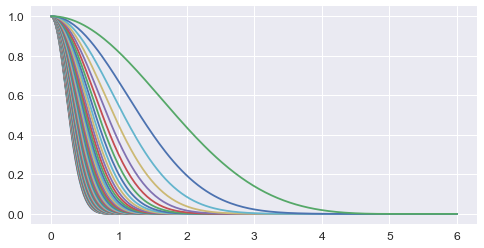

In [7]:
plot_cutoff_model(r_model_origin, 5)

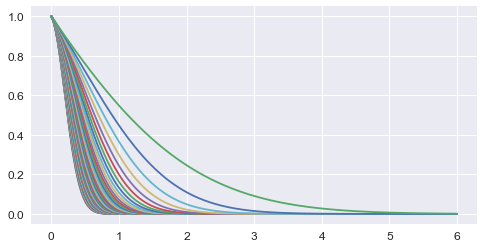

In [8]:
plot_damped_model(r_model_origin, 2, np.linspace(0, 5*1.2, 200))

### Evenly distributed 

In [9]:
r_model_evenly = (
    np.linspace(0.1,4, 50),
    np.linspace(30, 10, 50),
)

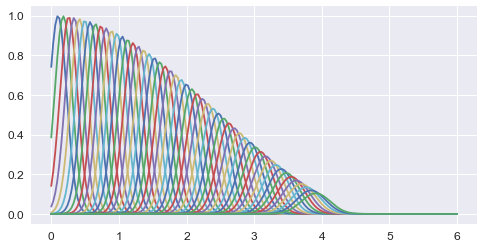

In [10]:
plot_cutoff_model(r_model_evenly, 5)

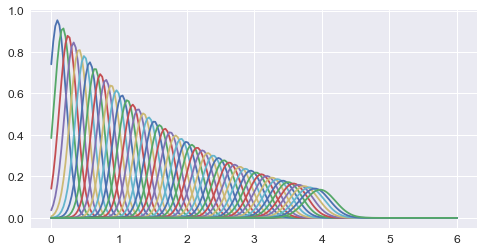

In [11]:
plot_damped_model(r_model_evenly, 2, np.linspace(0, 5*1.2, 200))

### Highest density around average bonding length

In [12]:
r_model_concentrated = (
    list(np.linspace(0.2, 0.7, 11))[:-1] + \
    list(np.linspace(0.7, 2.5, 30)) + \
    list(np.linspace(2.5, 4, 11))[1:],
    [500]*10 + \
    [1000]*30 + \
    [200]*10,
)

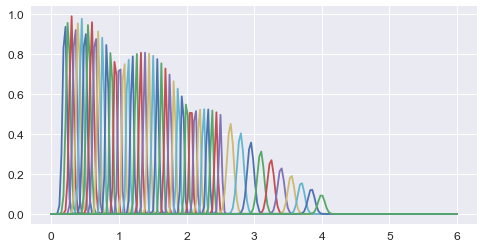

In [13]:
plot_cutoff_model(r_model_concentrated, 5)

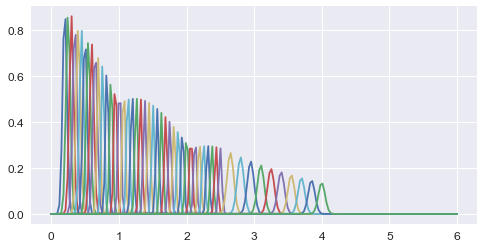

In [14]:
plot_damped_model(r_model_concentrated, 2, np.linspace(0, 5*1.2, 200))

## Aizimutahl 

In [15]:
phi_model_evenly = (
    np.linspace(0, 2*np.pi, 50),
    [300] * 50,
    2 * np.pi
)

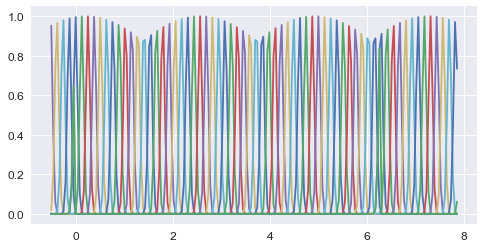

In [16]:
plot_periodic_model(phi_model_evenly, np.linspace(-0.5, 2.5*np.pi, 200))

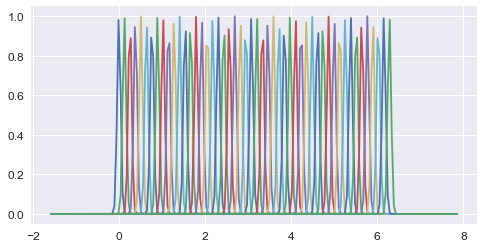

In [17]:
plot_normal_model(phi_model_evenly, np.linspace(-0.5*np.pi, 2.5*np.pi, 200))

### Polar, das gleiche wie bei Azimuthal 

In [18]:
theta_model_evenly = (
    np.linspace(0, np.pi, 50),
    [700] * 50,
    np.pi
)


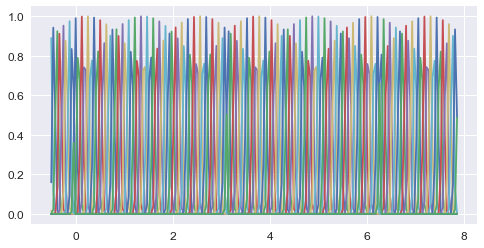

In [19]:
plot_periodic_model(theta_model_evenly, np.linspace(-0.5, 2.5*np.pi, 200))

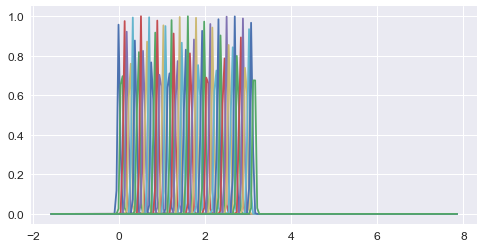

In [20]:
plot_normal_model(theta_model_evenly, np.linspace(-0.5*np.pi, 2.5*np.pi, 200))


# Train Benchmarksystem 

## Utilities 

In [21]:
from SCFInitialGuess.utilities.constants import number_of_basis_functions as N_BASIS
from SCFInitialGuess.utilities.dataset import extract_triu_batch, extract_triu
from SCFInitialGuess.utilities.dataset import StaticDataset




def extract_dataset(molecules, p_batch, descriptor):    
    
    from SCFInitialGuess.utilities.dataset import AbstractDataset

    G = []
    for mol in molecules:
        G.append(
            descriptor.calculate_all_descriptors(mol).flatten()
        )

    #G = np.asarray(G)
    
    p_triu = extract_triu_batch(p_batch, dim)
    
    return G, p_triu


def make_dataset(descriptor, dim):
    
    inputs_test, outputs_test = extract_dataset(
        molecules[2], 
        p_test.reshape(-1, dim, dim),
        descriptor
    )
    
    inputs_validation, outputs_validation = extract_dataset(
        molecules[1], 
        p_val.reshape(-1, dim, dim),
        descriptor
    )

    inputs_train, outputs_train = extract_dataset(
        molecules[0], 
        p_train.reshape(-1, dim, dim),
        descriptor
    )
    
    
    _, mu, std = StaticDataset.normalize(inputs_train + inputs_validation + inputs_test)
    
    dataset = StaticDataset(
        train=(
            StaticDataset.normalize(inputs_train, mean=mu, std=std)[0], 
            np.asarray(outputs_train)
        ),
        validation=(
            StaticDataset.normalize(inputs_validation, mean=mu, std=std)[0], 
            np.asarray(outputs_validation)
        ),
        test=(
            StaticDataset.normalize(inputs_test, mean=mu, std=std)[0], 
            np.asarray(outputs_test)
        ),
        mu=mu,
        std=std
    )
    
    return dataset

### NN 

In [22]:
#intializer = keras.initializers.TruncatedNormal(mean=0.0, stddev=0.01)

def make_model( 
        input_dim, 
        output_dim,
        activation="elu", 
        learning_rate=1e-3
    ):

    model = keras.Sequential()

    # linear model => 1 layer
    
    model.add(keras.layers.Dense(
        output_dim, 
        #activation=activation, 
        input_dim=input_dim, 
        #kernel_initializer=intializer, 
        #bias_initializer='zeros',
        kernel_regularizer=keras.regularizers.l2(1e-7)
    ))


    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate), 
        loss='MSE', 
        metrics=['mse']
    )
    
    return model



In [31]:
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_mean_squared_error", 
    min_delta=1e-7, 
    patience=100, 
    verbose=1
)

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_mean_squared_error', 
    factor=0.5, 
    patience=20, 
    verbose=1, 
    mode='auto', 
    min_delta=1e-6, 
    cooldown=10, 
    min_lr=1e-8
)

EPOCHS = 5000

def train_model(model, dataset, learning_rate=1e-3, epochs=EPOCHS):
    
    history = model.fit(
        x = dataset.training[0],
        y = dataset.training[1],
        epochs=epochs,
        shuffle=True,
        validation_data=dataset.validation, 
        verbose=0, 
        callbacks=[
            early_stopping, 
            reduce_lr
        ]
    )

    ind = np.argmin(history.history["val_mean_squared_error"])

    return history.history["mean_squared_error"][ind], history.history["val_mean_squared_error"][ind]
    

### Benchmarking

In [32]:
dim_triu = dim * (dim + 1) // 2

In [33]:
DIM = {
    "H": int(7*8 / 2),
    "C": int(22 * 23 / 2)
}

number_of_atoms = 6

def run_test(descriptor, n_tests=5):
    
    dataset = make_dataset(descriptor, dim)
    
    errors_train, errors_val = [], []
    for i in range(n_tests):
        print("\n\n--> Training: " + str(i+1))
        
        keras.backend.clear_session()
        
        model = make_model(
            descriptor.number_of_descriptors * number_of_atoms, 
            dim_triu
        )
        
        errors = train_model(model, dataset)
        errors_train.append(errors[0])
        errors_val.append(errors[1])
        print("\n--> Result: Train: {:0.4e} Vaidation: {:0.4e}".format(errors[0], errors[1]))
        
        
        
    return errors_train, errors_val

# Fetch old results 

In [4]:
results = np.load("data/DescriptorBenchmarkResults.npy")

# Do Benchmark

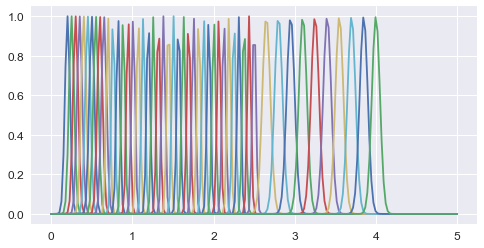

In [27]:
from SCFInitialGuess.descriptors.models import make_uniform
#plot_normal_model(make_uniform(5, 5, eta_max=10, eta_min=1), np.linspace(0, 5, 200))
plot_normal_model(r_model_concentrated, np.linspace(0, 5, 200))

In [36]:
from SCFInitialGuess.descriptors.high_level import NonWeighted, AtomicNumberWeighted, ElectronegativityWeighted
from SCFInitialGuess.descriptors.coordinate_descriptors import Gaussians, PeriodicGaussians
from SCFInitialGuess.descriptors.coordinate_descriptors import IndependentAngularDescriptor, SPHAngularDescriptor
from SCFInitialGuess.descriptors.cutoffs import BehlerCutoff1, Damping
from SCFInitialGuess.descriptors.models import \
    make_uniform, make_periodic_uniform

N_TESTS = 5

angular_descriptor_list = [
    IndependentAngularDescriptor(
        PeriodicGaussians(*make_periodic_uniform(20, 2*np.pi)), 
        PeriodicGaussians(*make_periodic_uniform(10, np.pi))
    ),
    SPHAngularDescriptor(3),
    SPHAngularDescriptor(6)
]

radial_descriptor_list = [
    Gaussians(*r_model_concentrated),
    Gaussians(*make_uniform(5, 5, eta_max=10, eta_min=1)), 
    Gaussians(*make_uniform(25, 5, eta_max=60, eta_min=20)), 
    Gaussians(*make_uniform(50, 5, eta_max=120, eta_min=40))
]

counter = 0
results = []

for HighLevelDescriptor in [NonWeighted, AtomicNumberWeighted, ElectronegativityWeighted]:
    for CutOff in [BehlerCutoff1(2.5), BehlerCutoff1(5), Damping(2)]:
        for radial_descriptor in radial_descriptor_list:
            for angular_descriptor in angular_descriptor_list:

                counter += 1

                print("\n\n\n\nTesting model: {0}\n".format(counter))

                descriptor = HighLevelDescriptor(
                    radial_descriptor,
                    angular_descriptor,
                    CutOff
                )
                print("dim_in: " + str(descriptor.number_of_descriptors * 6))

                errors_train, errors_val = run_test(descriptor, n_tests=N_TESTS)
                results.append((
                    [counter] * N_TESTS,
                    errors_train,
                    errors_val
                ))      






Testing model: 1

dim_in: 480


--> Training: 1

Epoch 00026: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 00055: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 00084: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Epoch 00106: early stopping

--> Result: Train: 1.1542e-02 Vaidation: 5.6492e-02


--> Training: 2

Epoch 00027: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 00056: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 00085: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Epoch 00107: early stopping

--> Result: Train: 8.9558e-03 Vaidation: 5.4764e-02


--> Training: 3

Epoch 00027: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 00056: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 00085: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Epoch 00107: early st

KeyboardInterrupt: 

In [ ]:
np.save("data/DescriptorBenchmarkResults.npy", results)

In [7]:
results = np.load("data/DescriptorBenchmarkResults.npy")

# Plot 

In [8]:
labels = []
x_data = []
y_train = []
y_val = []
for x, train, val in results:
    labels.append("Model {0}".format(int(x[0])))
    
    x_data += list(x)
    y_train += list(train)
    y_val += list(val)

In [9]:
np.isnan(np.array([1.0, 1 +2j, np.nan]))

array([False, False,  True])

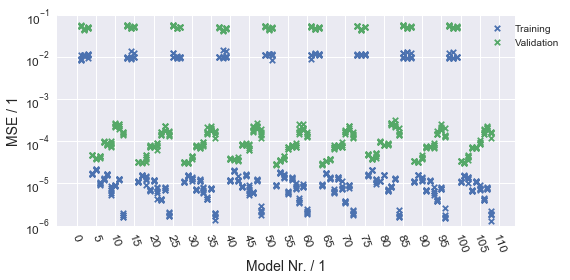

In [28]:
fig = plt.figure()
ax = plt.gca()

ax.scatter(x_data, y_train, s=30, marker="x", label="Training")
ax.scatter(x_data, y_val, s=30, marker="x", label="Validation")
ax.set_yscale('log')
plt.ylim(1e-6, 1e-1)

#xticks = np.arange(9) * 12 + 1
xticks = np.arange(0, 112, 5)
plt.xticks(xticks, xticks, rotation=-70)
#plt.xticks(np.arange(1, len(labels)+1), labels, rotation=-70, fontsize=4)

plt.xlabel("Model Nr. / 1")
plt.ylabel("MSE / 1")

#plt.legend()
plt.legend(bbox_to_anchor=(0.92, 1))
plt.tight_layout()

fig.subplots_adjust(right=0.9)
#plt.tight_layout(rect=[0, 0, 0.88, 1])


plt.savefig("/home/jo/Repos/MastersThesis/GenericDescriptors/figures/DescriptorBenchmark.pdf")

plt.show()



In [ ]:
3*3*4*3